# Inputting ABM outputs into PV ICE 

## Import libraries and create test folder

In [1]:
import PV_ICE
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
testfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'TEMP')
baselinesfolder =  str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
# Another option using relative address; for some operative systems you might need '/' instead of '\'
# testfolder = os.path.abspath(r'..\..\PV_ICE\TEMP')  

print ("Your simulation will be stored in %s" % testfolder)
print(baselinesfolder)

Your simulation will be stored in C:\Users\ahegedus\Documents\GitHub\PV_ICE\PV_ICE\TEMP
C:\Users\ahegedus\Documents\GitHub\PV_ICE\PV_ICE\baselines


## Create simulation

In [3]:
#create simulation
r1 = PV_ICE.Simulation(name='ABM_Simulation', path=testfolder)
#create 10 scenarios in simulation: 1st is standard in PV ICE, 2-10 are scenarios a-i in ABM
SCENARIOS = ['standard_PVICE','landfill_ban','high_mat_recovery_cheap_recycling','cheap_recycling','high_landfill_costs','better_lifetime','better_learning','reuse_warranties','seeding_reuse','juliens_baseline']
for myscenario in SCENARIOS:
    r1.createScenario(name=myscenario, file=r'..\baselines\baseline_modules_US.csv')
    r1.scenario[myscenario].addMaterial('glass', file=r'..\baselines\baseline_material_glass.csv')
    r1.scenario[myscenario].addMaterial('aluminium_frames', file=r'..\baselines\baseline_material_aluminium_frames.csv')
    r1.scenario[myscenario].addMaterial('silver', file=r'..\baselines\baseline_material_silver.csv')
    r1.scenario[myscenario].addMaterial('silicon', file=r'..\baselines\baseline_material_silicon.csv')
    r1.scenario[myscenario].addMaterial('copper', file=r'..\baselines\baseline_material_copper.csv')

path = C:\Users\ahegedus\Documents\GitHub\PV_ICE\PV_ICE\TEMP


## Modify Parameters

In [4]:
#modify values of each scenario 2-10 based on ABM outputs
#first, set 'mod_EOL_collected_recycled' to 100% in scenarios 2-10 for years 2022 on (assume all collected materials are recycled)
ABM_SCENARIOS = SCENARIOS[1:] 
past_years_collected_recycled = [r1.scenario['standard_PVICE'].data['mod_EOL_collected_recycled'][0]]*(2022-1995)
new_collected_recycled = [100]*(2050-2021)
#create new list to replace 'mod_EOL_collected_recycled' with, with 1995-2021 original baseline module values, and 2022-2050 at 100%
new_mod_recycled = past_years_collected_recycled + new_collected_recycled
for myscenario in ABM_SCENARIOS:
    r1.scenario[myscenario].data['mod_EOL_collected_recycled'] = new_mod_recycled

#next, modify 3 additional inputs for each scenario 2-10, with values depending on the scenario, coming from ABM outputs
MODIFIED_MODULE_BASELINES = ['mod_Repair','mod_Reuse','mod_EOL_collection_eff']
len(r1.scenario['landfill_ban'].data['mod_Reuse']) #all inputs have 56 rows
#keep first 27 rows corresponding to 1995-2021 values
ABM_outputs = pd.read_csv(r'..\baselines\ABM\abm_outputs_mass_fractions.csv')

In [5]:
#ABM_outputs
#change scenario names to names from ABM_SCENARIOS
file_scenario_names = ABM_outputs['Scenario'].unique().tolist()
ABM_outputs = ABM_outputs.replace(file_scenario_names, ABM_SCENARIOS)

In [6]:
#changing repair, eol collection eff, and reuse module baselines for all ABM scenarios
for myscenario in ABM_SCENARIOS:
    frames1 = []
    frames2 = []
    frames3 = []
    new_outputs = []
    scenario_filter = []
    new_mod_Repairing = []
    new_mod_Recycling = []
    new_mod_Reuse = []
    scenario_filter = 'Scenario == ' + '\"' + myscenario + '\"'
    new_outputs = ABM_outputs.query(scenario_filter)
    #replace repairing baselines
    repairs = new_outputs.loc[:,'mass_fraction_PV_materials_repaired_milliontonnes']*100
    repairs.index = list(range(31))
    frames1 = [r1.scenario[myscenario].data['mod_Repair'][0:27],repairs[2:]]
    new_mod_Repairing = pd.concat(frames1)
    r1.scenario[myscenario].data['mod_Repair'] = new_mod_Repairing.values
    #replace recycling baselines
    recycles = new_outputs.loc[:,'mass_fraction_PV_materials_recycled_milliontonnes']*100
    recycles.index = list(range(31))
    frames2 = [r1.scenario[myscenario].data['mod_EOL_collection_eff'][0:27],recycles[2:]]
    new_mod_Recycling = pd.concat(frames2)
    r1.scenario[myscenario].data['mod_EOL_collection_eff'] = new_mod_Recycling.values
    #replace reuse baselines
    reuses = new_outputs.loc[:,'mass_fraction_PV_materials_reused_milliontonnes']*100
    reuses.index = list(range(31))
    frames3 = [r1.scenario[myscenario].data['mod_Reuse'][0:27],reuses[2:]]
    new_mod_Reuse = pd.concat(frames3)
    r1.scenario[myscenario].data['mod_Reuse'] = new_mod_Reuse.values
    print(myscenario)

landfill_ban
high_mat_recovery_cheap_recycling
cheap_recycling
high_landfill_costs
better_lifetime
better_learning
reuse_warranties
seeding_reuse
juliens_baseline


### Improved Lifetime Baselines calculations for better_lifetime mod_lifetime input

In [7]:
def lifetime_line(year):
    """"
    This function takes in a year and outputs the module lifetime based on scenario e) in ABM.
    Inputs
    year = desired year
    """
    m = (60-15.9)/(2050-2000)
    y = m*(year-2000) + 15.9
    return(y)

In [8]:
#create list of mod_lifetime values based on linear regression
years = list(range(2000,2051))
mod_lifetimes_list = []
for myyear in years:
    mod_lifetimes_list += [lifetime_line(myyear)]

In [9]:
mod_lifetimes_df = pd.DataFrame()

In [10]:
mod_lifetimes_df['year'] = years
mod_lifetimes_df['mod_lifetime'] = mod_lifetimes_list

In [11]:
#changing mod_lifetime in scenario e) better_lifetime
new_mod_lifetime = list(r1.scenario[myscenario].data['mod_lifetime'][0:5].values) + mod_lifetimes_list
r1.scenario['better_lifetime'].data['mod_lifetime'] = new_mod_lifetime

### Now all of the parameters are properly modified!

## Run Mass Flow Calculations

In [12]:
r1.calculateMassFlow()

Working on Scenario:  standard_PVICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  landfill_ban
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_mat_recovery_cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
=

## Initial plotting of results

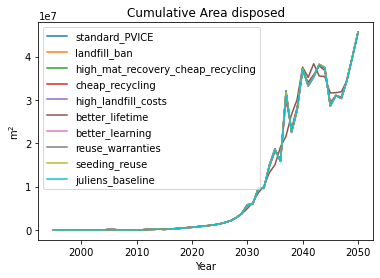

In [13]:
r1.plotScenariosComparison(keyword='Cumulative_Area_disposed')

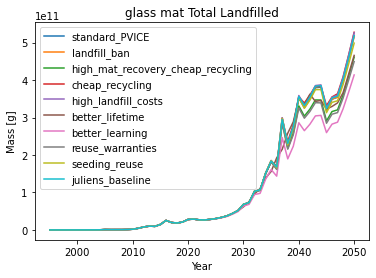

In [14]:
r1.plotMaterialComparisonAcrossScenarios(material='glass', keyword='mat_Total_Landfilled')

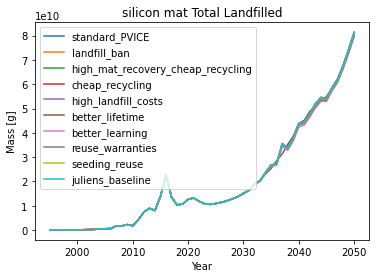

In [15]:
r1.plotMaterialComparisonAcrossScenarios(material='silicon', keyword='mat_Total_Landfilled')

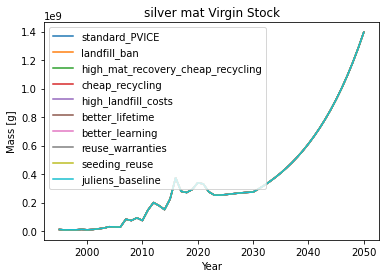

In [16]:
r1.plotMaterialComparisonAcrossScenarios(material='silver', keyword='mat_Virgin_Stock') #all the same values?

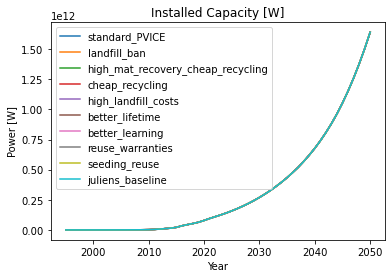

In [17]:
r1.plotScenariosComparison(keyword='Installed_Capacity_[W]') #?!?!?!

### Creating a summary of results in a new data frame

In [18]:
USyearly=pd.DataFrame()

In [19]:
keyword='mat_Virgin_Stock'
materials = ['glass', 'aluminium_frames','silicon', 'silver', 'copper']

# Loop over Scenarios
for jj in range(0, len(r1.scenario)): #goes from 0 to 9
    case = list(r1.scenario.keys())[jj] #case gives scenario name
    for ii in range (0, len(materials)):    
        material = materials[ii]
        foo = r1.scenario[case].material[material].materialdata[keyword].copy()
        foo = foo.to_frame(name=material)
        USyearly["VirginStock_"+material+'_'+r1.name+'_'+case] = foo[material]
    filter_col = [col for col in USyearly if (col.startswith('VirginStock') and col.endswith(r1.name+'_'+case)) ]
    USyearly['VirginStock_Module_'+r1.name+'_'+case] = USyearly[filter_col].sum(axis=1)
#took module sum out of inner loop to fix module sum error

In [20]:
keyword='mat_Total_Landfilled'
materials = ['glass', 'aluminium_frames','silicon', 'silver', 'copper']

# Loop over Scenarios
for jj in range(0, len(r1.scenario)): #goes from 0 to 9
    case = list(r1.scenario.keys())[jj]
    for ii in range (0, len(materials)):    
        material = materials[ii]
        foo = r1.scenario[case].material[material].materialdata[keyword].copy()
        foo = foo.to_frame(name=material)
        USyearly["Waste_"+material+'_'+r1.name+'_'+case] = foo[material]
    filter_col = [col for col in USyearly if (col.startswith('Waste') and col.endswith(r1.name+'_'+case)) ]
    USyearly['Waste_Module_'+r1.name+'_'+case] = USyearly[filter_col].sum(axis=1)

In [21]:
keyword='mat_Total_EOL_Landfilled'
materials = ['glass', 'aluminium_frames','silicon', 'silver', 'copper']

# Loop over Scenarios
for jj in range(0, len(r1.scenario)): #goes from 0 to 9
    case = list(r1.scenario.keys())[jj]
    for ii in range (0, len(materials)):    
        material = materials[ii]
        foo = r1.scenario[case].material[material].materialdata[keyword].copy()
        foo = foo.to_frame(name=material)
        USyearly["Waste_EOL_"+material+'_'+r1.name+'_'+case] = foo[material]
    filter_col = [col for col in USyearly if (col.startswith('Waste_EOL') and col.endswith(r1.name+'_'+case)) ]
    USyearly['Waste_EOL_Module_'+r1.name+'_'+case] = USyearly[filter_col].sum(axis=1)

In [22]:
USyearly = USyearly/1000000  #Convert to metric tonnes
#907185 -- this is for US tons

In [23]:
keyword='new_Installed_Capacity_[MW]'

newcolname = keyword+'_'+r1.name
    
if newcolname in USyearly:
    USyearly[newcolname] = USyearly[newcolname]+r1.scenario[list(r1.scenario.keys())[0]].data[keyword]
else:
    USyearly[keyword+'_'+r1.name] = r1.scenario[list(r1.scenario.keys())[0]].data[keyword]

In [24]:
UScum = USyearly.copy()
UScum = UScum.cumsum()

In [25]:
keyword='Installed_Capacity_[W]'

# Loop over Scenarios
for i in range(0, len(r1.scenario)):
    case = list(r1.scenario.keys())[i]
    foo = r1.scenario[case].data[keyword]
    foo = foo.to_frame(name=keyword)
    UScum["Capacity_"+r1.name+'_'+case] = foo[keyword].values #this needs to be .values
    ########SHOULD THIS BE CHANGED TO BE IN MW?

In [26]:
USyearly.index = r1.scenario['standard_PVICE'].data['year']
UScum.index = r1.scenario['standard_PVICE'].data['year']

In [27]:
USyearly.to_csv('ABM_Yearly_Results.csv')
UScum.to_csv('ABM_Cumulative_Results.csv')

### Plotting with USyearly and UScum data frames

Cumulative Virgin Needs by 2050 Million Tones by Scenario


<ipython-input-28-707bcb3e413a>:90: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  a1.set_xticks(ind, ('S1', 'S2'))


0    90.252802
1    90.246084
dtype: float64

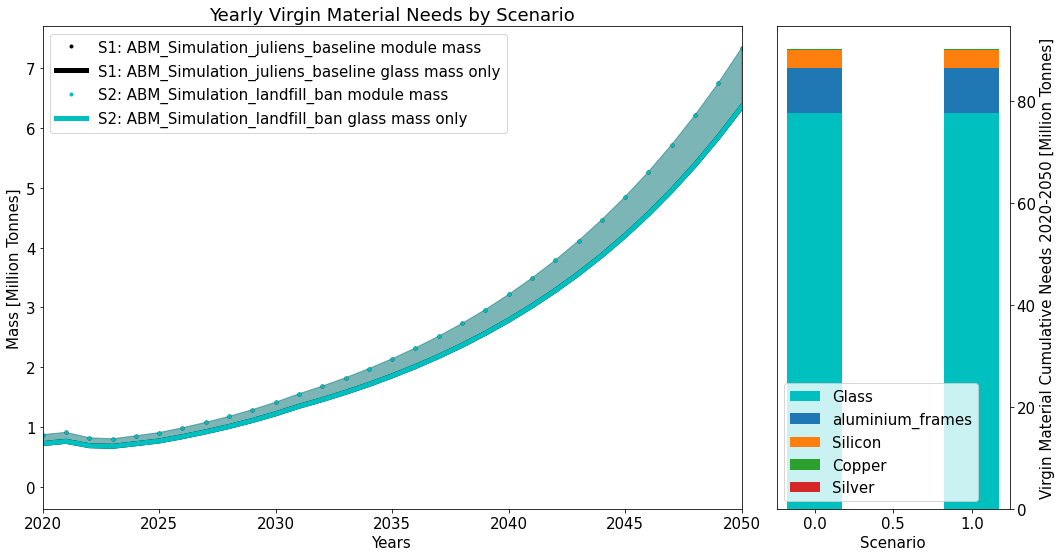

In [28]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (15, 8)
keyw='VirginStock_'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminium_frames']


f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
   
########################    
# SUBPLOT 1
########################
#######################
    
    
# Loop over scenarios
name0 = 'ABM_Simulation_juliens_baseline'
name2 = 'ABM_Simulation_landfill_ban'


# SCENARIO 1 ***************
modulemat = (USyearly[keyw+materials[0]+'_'+name0]+USyearly[keyw+materials[1]+'_'+name0]+
            USyearly[keyw+materials[2]+'_'+name0]+USyearly[keyw+materials[3]+'_'+name0]+
            USyearly[keyw+materials[4]+'_'+name0])
glassmat = (USyearly[keyw+materials[0]+'_'+name0])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(USyearly.index, modulemat, 'k.', linewidth=5, label='S1: '+name0+' module mass')
a0.plot(USyearly.index, glassmat, 'k', linewidth=5, label='S1: '+name0+' glass mass only')
a0.fill_between(USyearly.index, glassmat, modulemat, color='k', alpha=0.3,
                 interpolate=True)

# SCENARIO 2 ***************
modulemat = (USyearly[keyw+materials[0]+'_'+name2]+USyearly[keyw+materials[1]+'_'+name2]+
            USyearly[keyw+materials[2]+'_'+name2]+USyearly[keyw+materials[3]+'_'+name2]+
            USyearly[keyw+materials[4]+'_'+name2])
glassmat = (USyearly[keyw+materials[0]+'_'+name2])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(USyearly.index, modulemat, 'c.', linewidth=5, label='S2: '+name2+' module mass')
a0.plot(USyearly.index, glassmat, 'c', linewidth=5, label='S2: '+name2+' glass mass only')
a0.fill_between(USyearly.index, glassmat, modulemat, color='c', alpha=0.3,
                 interpolate=True)

a0.legend()
a0.set_title('Yearly Virgin Material Needs by Scenario')
a0.set_ylabel('Mass [Million Tonnes]')
a0.set_xlim([2020, 2050])
a0.set_xlabel('Years')

##same values for yearly virgin material demand?! something went wrong.....?
########################    
# SUBPLOT 2
########################
#######################
# Calculate    

cumulations2050 = {}
for ii in range(0, len(materials)):
    matcum = []
    matcum.append(UScum[keyw+materials[ii]+'_'+name0].loc[2050])
    matcum.append(UScum[keyw+materials[ii]+'_'+name2].loc[2050])
    cumulations2050[materials[ii]] = matcum

dfcumulations2050 = pd.DataFrame.from_dict(cumulations2050) 
dfcumulations2050 = dfcumulations2050/1000000   # in Million Tonnes

dfcumulations2050['bottom1'] = dfcumulations2050['glass']
dfcumulations2050['bottom2'] = dfcumulations2050['bottom1']+dfcumulations2050['aluminium_frames']
dfcumulations2050['bottom3'] = dfcumulations2050['bottom2']+dfcumulations2050['silicon']
dfcumulations2050['bottom4'] = dfcumulations2050['bottom3']+dfcumulations2050['copper']


## Plot BARS Stuff
ind=np.arange(2)
width=0.35 # width of the bars.
p0 = a1.bar(ind, dfcumulations2050['glass'], width, color='c')
p1 = a1.bar(ind, dfcumulations2050['aluminium_frames'], width,
             bottom=dfcumulations2050['bottom1'])
p2 = a1.bar(ind, dfcumulations2050['silicon'], width,
             bottom=dfcumulations2050['bottom2'])
p3 = a1.bar(ind, dfcumulations2050['copper'], width,
             bottom=dfcumulations2050['bottom3'])
p4 = a1.bar(ind, dfcumulations2050['silver'], width,
             bottom=dfcumulations2050['bottom4'])

a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('Virgin Material Cumulative Needs 2020-2050 [Million Tonnes]')
a1.set_xlabel('Scenario')
a1.set_xticks(ind, ('S1', 'S2'))
#plt.yticks(np.arange(0, 81, 10))
a1.legend((p0[0], p1[0], p2[0], p3[0], p4[0] ), ('Glass', 'aluminium_frames', 'Silicon','Copper','Silver'))

f.tight_layout()

print("Cumulative Virgin Needs by 2050 Million Tones by Scenario")
dfcumulations2050[['glass','silicon','silver','copper','aluminium_frames']].sum(axis=1)

Cumulative Waste by EoL 2050 Million Tones by Scenario


<ipython-input-29-73f9a6f197b3>:88: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  a1.set_xticks(ind, ('S1', 'S2'))


0    5.881872
1    5.940831
dtype: float64

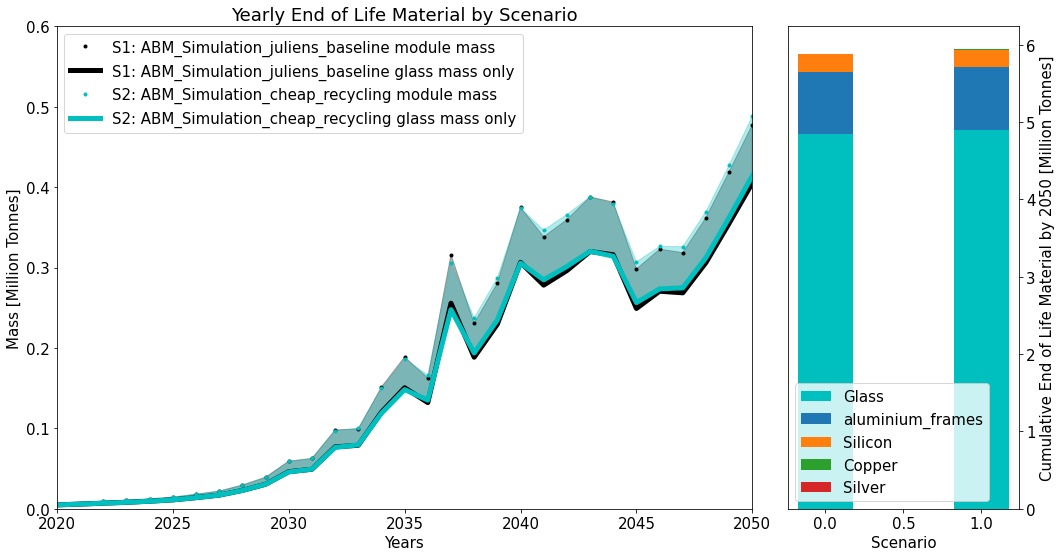

In [29]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (15, 8)
keyw='Waste_EOL_'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminium_frames']


f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

########################    
# SUBPLOT 1
########################
#######################
   
# Loop over CASES
name0 = 'ABM_Simulation_juliens_baseline'
name2 = 'ABM_Simulation_cheap_recycling'

# SCENARIO 1 ***************
modulemat = (USyearly[keyw+materials[0]+'_'+name0]+USyearly[keyw+materials[1]+'_'+name0]+
            USyearly[keyw+materials[2]+'_'+name0]+USyearly[keyw+materials[3]+'_'+name0]+
            USyearly[keyw+materials[4]+'_'+name0])
glassmat = (USyearly[keyw+materials[0]+'_'+name0])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(USyearly.index, modulemat, 'k.', linewidth=5, label='S1: '+name0+' module mass')
a0.plot(USyearly.index, glassmat, 'k', linewidth=5, label='S1: '+name0+' glass mass only')
a0.fill_between(USyearly.index, glassmat, modulemat, color='k', alpha=0.3,
                 interpolate=True)

# SCENARIO 2 ***************
modulemat = (USyearly[keyw+materials[0]+'_'+name2]+USyearly[keyw+materials[1]+'_'+name2]+
            USyearly[keyw+materials[2]+'_'+name2]+USyearly[keyw+materials[3]+'_'+name2]+
            USyearly[keyw+materials[4]+'_'+name2])
glassmat = (USyearly[keyw+materials[0]+'_'+name2])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(USyearly.index, modulemat, 'c.', linewidth=5, label='S2: '+name2+' module mass')
a0.plot(USyearly.index, glassmat, 'c', linewidth=5, label='S2: '+name2+' glass mass only')
a0.fill_between(USyearly.index, glassmat, modulemat, color='c', alpha=0.3,
                 interpolate=True)

a0.legend()
a0.set_title('Yearly End of Life Material by Scenario')
a0.set_ylabel('Mass [Million Tonnes]')
a0.set_xlim([2020, 2050])
a0.set_xlabel('Years')
a0.set_ylim([0, 0.6])

########################    
# SUBPLOT 2
########################
#######################
# Calculate    

cumulations2050 = {}
for ii in range(0, len(materials)):
    matcum = []
    matcum.append(UScum[keyw+materials[ii]+'_'+name0].loc[2050])
    matcum.append(UScum[keyw+materials[ii]+'_'+name2].loc[2050])
    cumulations2050[materials[ii]] = matcum

dfcumulations2050 = pd.DataFrame.from_dict(cumulations2050) 
dfcumulations2050 = dfcumulations2050/1000000   # in Million Tonnes

dfcumulations2050['bottom1'] = dfcumulations2050['glass']
dfcumulations2050['bottom2'] = dfcumulations2050['bottom1']+dfcumulations2050['aluminium_frames']
dfcumulations2050['bottom3'] = dfcumulations2050['bottom2']+dfcumulations2050['silicon']
dfcumulations2050['bottom4'] = dfcumulations2050['bottom3']+dfcumulations2050['copper']


## Plot BARS Stuff
ind=np.arange(2)
width=0.35 # width of the bars.
p0 = a1.bar(ind, dfcumulations2050['glass'], width, color='c')
p1 = a1.bar(ind, dfcumulations2050['aluminium_frames'], width,
             bottom=dfcumulations2050['bottom1'])
p2 = a1.bar(ind, dfcumulations2050['silicon'], width,
             bottom=dfcumulations2050['bottom2'])
p3 = a1.bar(ind, dfcumulations2050['copper'], width,
             bottom=dfcumulations2050['bottom3'])
p4 = a1.bar(ind, dfcumulations2050['silver'], width,
             bottom=dfcumulations2050['bottom4'])

a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('Cumulative End of Life Material by 2050 [Million Tonnes]')
a1.set_xlabel('Scenario')
a1.set_xticks(ind, ('S1', 'S2'))
#plt.yticks(np.arange(0, 81, 10))
a1.legend((p0[0], p1[0], p2[0], p3[0], p4[0] ), ('Glass', 'aluminium_frames', 'Silicon','Copper','Silver'))

f.tight_layout()

print("Cumulative Waste by EoL 2050 Million Tones by Scenario")
dfcumulations2050[['glass','silicon','silver','copper','aluminium_frames']].sum(axis=1)

## Clean up results for OpenEI export

### Yearly Results

In [30]:
yearly_scenario_comparison = pd.DataFrame()

In [31]:
#use scenarios as values
years = USyearly.index
yearly_scenario_comparison['@timeseries|Year'] = list(years)

In [32]:
scenarios = ['standard_PVICE','landfill_ban','high_mat_recovery_cheap_recycling','cheap_recycling','high_landfill_costs','better_lifetime','better_learning','reuse_warranties','seeding_reuse','juliens_baseline']
pretty_scenarios = ['PV ICE Baseline','Landfill Ban','High material recovery and Lower recycling costs','Lower recycling costs','Higher landfill costs','Improved lifetime','Improved learning effect','Reuse warranties','Seeding reuse','ABM Baseline']

#virgin material demand columns
for myscenario in scenarios:
    better_scenario_name = pretty_scenarios[scenarios.index(myscenario)]
    virgin_material_demand = USyearly['VirginStock_glass_ABM_Simulation_' + myscenario] + USyearly['VirginStock_aluminium_frames_ABM_Simulation_' + myscenario] + USyearly['VirginStock_silver_ABM_Simulation_' + myscenario] + USyearly['VirginStock_silicon_ABM_Simulation_' + myscenario] + USyearly['VirginStock_copper_ABM_Simulation_' + myscenario]
    yearly_scenario_comparison['@value|TotalVirginMaterialDemand|' + better_scenario_name + '#MetricTonnes'] = list(virgin_material_demand.values)
    

In [33]:
#EOL material columns
for myscenario in scenarios:
    better_scenario_name = pretty_scenarios[scenarios.index(myscenario)]
    total_eol_material = USyearly['Waste_EOL_glass_ABM_Simulation_' + myscenario] + USyearly['Waste_EOL_aluminium_frames_ABM_Simulation_' + myscenario] + USyearly['Waste_EOL_silver_ABM_Simulation_' + myscenario] + USyearly['Waste_EOL_silicon_ABM_Simulation_' + myscenario] + USyearly['Waste_EOL_copper_ABM_Simulation_' + myscenario]
    yearly_scenario_comparison['@value|TotalEOLMaterial|' + better_scenario_name + '#MetricTonnes'] = list(total_eol_material.values)

In [34]:
###############WHAT NEXT?

In [35]:
yearly_scenario_comparison.to_csv('ABM_Yearly, with Scenario Comparison, Materials Summed.csv')

### Cumulative Results

In [36]:
cumulative_ABM = pd.DataFrame()

In [37]:
scenarios = ['standard_PVICE','landfill_ban','high_mat_recovery_cheap_recycling','cheap_recycling','high_landfill_costs','better_lifetime','better_learning','reuse_warranties','seeding_reuse','juliens_baseline']
pretty_scenarios = ['PV ICE Baseline','Landfill Ban','High material recovery and Lower recycling costs','Lower recycling costs','Higher landfill costs','Improved lifetime','Improved learning effect','Reuse warranties','Seeding reuse','ABM Baseline']
list1 = []
for myscenario in pretty_scenarios: 
    list1 += [myscenario] * (2050-1994)
cumulative_ABM['@scenario|Intervention Scenario'] = list1

In [38]:
years = USyearly.index
cumulative_ABM['@timeseries|Year'] = list(years) * 10

In [39]:
#Virgin Material Demand Columns
materials = ['glass','aluminium_frames','silver','silicon','copper']
pretty_materials = ['Glass','AluminiumFrames','Silver','Silicon','Copper']
for mymaterial in materials:
    better_material_name = pretty_materials[materials.index(mymaterial)]
    virgin_material_demand = []
    for myscenario in scenarios: 
        virgin_material_demand += list(UScum['VirginStock_'+ mymaterial + '_ABM_Simulation_'+ myscenario].values)
    cumulative_ABM['@value|VirginMaterialDemand|' + better_material_name + '#MetricTonnes'] = virgin_material_demand

In [40]:
#EOL Material Columns
materials = ['glass','aluminium_frames','silver','silicon','copper']
pretty_materials = ['Glass','AluminiumFrames','Silver','Silicon','Copper']
for mymaterial in materials:
    better_material_name = pretty_materials[materials.index(mymaterial)]
    eol_material = []
    for myscenario in scenarios: 
        eol_material += list(UScum['Waste_EOL_'+ mymaterial + '_ABM_Simulation_'+ myscenario].values)
    cumulative_ABM['@value|EOLMaterial|' + better_material_name + '#MetricTonnes'] = eol_material

In [41]:
#filter for decade increments
df_new = cumulative_ABM.rename(columns={'@timeseries|Year':'year'})
cumulative_ABM = cumulative_ABM[df_new.year.isin([2020, 2030,2040,2050])]
cumulative_ABM = cumulative_ABM.rename(columns={'year':'@timeseries|Year'})

In [42]:
###############WHAT NEXT?

In [43]:
cumulative_ABM.to_csv('ABM_Cumulative with Decade Increments.csv')

In [44]:
#create a cumulative at 2050 file
cumulative_ABM_2050 = pd.DataFrame()

In [45]:
cumulative_ABM_2050["@scenario|PVICEOutput"] = ['Virgin Material Demand MT','EOL Material MT','Installed Capacity MW']

In [46]:
cumulative_ABM_2050["@timeseries|Year"] = [2050,2050,2050]

In [47]:
UScum2050 = UScum.iloc[-1:]
scenarios = ['standard_PVICE','landfill_ban','high_mat_recovery_cheap_recycling','cheap_recycling','high_landfill_costs','better_lifetime','better_learning','reuse_warranties','seeding_reuse','juliens_baseline']
pretty_scenarios = ['PV ICE Baseline','Landfill Ban','High material recovery and Lower recycling costs','Lower recycling costs','Higher landfill costs','Improved lifetime','Improved learning effect','Reuse warranties','Seeding reuse','ABM Baseline']
list1 = []
for myscenario in scenarios: 
    better_scenario_name = pretty_scenarios[scenarios.index(myscenario)]
    virgin_material_demand = [UScum2050['VirginStock_Module_ABM_Simulation_' + myscenario].values] #MT
    eol_material = [UScum2050['Waste_EOL_Module_ABM_Simulation_' + myscenario].values] #MT
    installed_capacity = [UScum2050['Capacity_ABM_Simulation_' + myscenario].values/1000000] #MW
    cumulative_ABM_2050['@value|InterventionScenario|'+better_scenario_name+'#Units'] = virgin_material_demand + eol_material + installed_capacity

In [48]:
cumulative_ABM_2050 = cumulative_ABM_2050.applymap(str)
colnames = list(cumulative_ABM_2050.columns)[1:]
for col in colnames:
    cumulative_ABM_2050[col] = cumulative_ABM_2050[col].str.strip('[]')

In [49]:
cumulative_ABM_2050.to_csv('ABM_cumulative_at_2050_toOPENEI.csv')

### Create Installed Capacity CSV

In [50]:
installed_capacity = pd.DataFrame()

In [51]:
years = USyearly.index
installed_capacity['@timeseries|Year'] = years

In [52]:
scenarios = ['standard_PVICE','landfill_ban','high_mat_recovery_cheap_recycling','cheap_recycling','high_landfill_costs','better_lifetime','better_learning','reuse_warranties','seeding_reuse','juliens_baseline']
pretty_scenarios = ['PV ICE Baseline','Landfill Ban','High material recovery and Lower recycling costs','Lower recycling costs','Higher landfill costs','Improved lifetime','Improved learning effect','Reuse warranties','Seeding reuse','ABM Baseline']
for myscenario in scenarios:
    capacity = UScum['Capacity_ABM_Simulation_'+ myscenario]
    better_scenario_name = pretty_scenarios[scenarios.index(myscenario)]
    installed_capacity['@value|InstalledCapacity|' + better_scenario_name + '#MW'] = list(capacity.values/1000000) #convert from W to MW

In [53]:
installed_capacity.to_csv('ABM_installed_capacity.csv')

### Calculating Number of Less Installs Needed For Each Scenario

In [56]:
Under_Installment = []
for i in range (0, len(r1.scenario['juliens_baseline'].data)): #runs for each year
    Under_Installment = ( (r1.scenario['juliens_baseline'].data['Installed_Capacity_[W]'][i] - 
                         r1.scenario['landfill_ban'].data['Installed_Capacity_[W]'][i])/1000000 )  # MWATTS
    r1.scenario['landfill_ban'].data['new_Installed_Capacity_[MW]'][i] += Under_Installment
    r1.calculateMassFlow()
####this took so long, is there a way to only run with one scenario?
###how to plot results?

<ipython-input-56-0d51d0ea7ba9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r1.scenario['landfill_ban'].data['new_Installed_Capacity_[MW]'][i] += Under_Installment


Working on Scenario:  standard_PVICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  landfill_ban
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_mat_recovery_cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
=

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  standard_PVICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  landfill_ban
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_mat_recovery_cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on M

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  juliens_baseline
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  standard_PVICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  landfill_ban
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  seeding_reuse
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  juliens_baseline
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  standard_PVICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silve

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  reuse_warranties
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  seeding_reuse
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  juliens_baseline
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  sil

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  better_learning
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  reuse_warranties
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  seeding_reuse
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silv

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  better_lifetime
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  better_learning
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  reuse_warranties
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  si

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_landfill_costs
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  better_lifetime
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  better_learning
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material : 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_landfill_costs
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  better_lifetime
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material : 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_mat_recovery_cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_landfill_costs
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Work

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  landfill_ban
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_mat_recovery_cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  standard_PVICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  landfill_ban
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_mat_recovery_cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on M

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  juliens_baseline
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  standard_PVICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  landfill_ban
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  seeding_reuse
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  juliens_baseline
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  standard_PVICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silve

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  reuse_warranties
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  seeding_reuse
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  juliens_baseline
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  sil

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  better_learning
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  reuse_warranties
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  seeding_reuse
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silv

Working on Scenario:  high_landfill_costs
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  better_lifetime
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  better_learning
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  reuse_warranties
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Workin

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_landfill_costs
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  better_lifetime
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  better_learning
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material : 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_landfill_costs
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  better_lifetime
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material : 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_mat_recovery_cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_landfill_costs
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Work